In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso



In [42]:
df=pd.read_csv("household_power_consumption.csv\household_power_consumption.csv")
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0
...,...,...,...,...,...,...,...,...,...
1048570,13/12/2008,21:34:00,0.426,0.076,242.27,1.8,0,0,0.0
1048571,13/12/2008,21:35:00,0.424,0.076,242.1,1.8,0,0,0.0
1048572,13/12/2008,21:36:00,0.422,0.076,241.73,1.8,0,0,0.0
1048573,13/12/2008,21:37:00,0.422,0.078,242.56,1.8,0,0,0.0


In [43]:
df=pd.read_csv("household_power_consumption.csv\household_power_consumption.csv",
               sep=",",
               parse_dates={'DateTime':['Date','Time']},
               infer_datetime_format=True,
               low_memory=False,
               na_values=['?'])

df=df.set_index('DateTime')


C:\Users\irams\AppData\Local\Temp\ipykernel_20376\3866634753.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df=pd.read_csv("household_power_consumption.csv\household_power_consumption.csv",
C:\Users\irams\AppData\Local\Temp\ipykernel_20376\3866634753.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv("household_power_consumption.csv\household_power_consumption.csv",
C:\Users\irams\AppData\Local\Temp\ipykernel_20376\3866634753.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df=pd.read_csv("household_power

In [44]:
df['Energy_kwh']=df['Global_active_power']*(1/60)
# # df


In [45]:
daily_df=df.resample('D').sum()[['Energy_kwh']]
# # daily_df

In [46]:
daily_df['day_of_week']=daily_df.index.dayofweek
daily_df['month']=daily_df.index.month
daily_df['is_weekend']=(daily_df.index.dayofweek >=5).astype(int)


In [47]:
daily_df['lag1']=daily_df['Energy_kwh'].shift(1)
daily_df['lag7']=daily_df['Energy_kwh'].shift(7)
daily_df['rolling_mean_7'] = daily_df['Energy_kwh'].shift(1).rolling(7).mean()

daily_df

,Energy_kwh,day_of_week,month,is_weekend,lag1,lag7,rolling_mean_7
DateTime,,,,,,,
2006-12-16,20.152933,5,12,1,NaN,NaN,NaN
2006-12-17,56.507667,6,12,1,20.152933,NaN,NaN
2006-12-18,36.730433,0,12,0,56.507667,NaN,NaN
2006-12-19,27.769900,1,12,0,36.730433,NaN,NaN
2006-12-20,37.095800,2,12,0,27.769900,NaN,NaN
...,...,...,...,...,...,...,...
2008-12-09,33.385733,1,12,0,31.143933,29.890733,33.821610
2008-12-10,35.183667,2,12,0,33.385733,29.252733,34.320895
2008-12-11,23.875367,3,12,0,35.183667,28.977300,35.168171


In [48]:
daily_df['avg_voltage'] = df['Voltage'].resample('D').mean()
daily_df['avg_intensity'] = df['Global_intensity'].resample('D').mean()
daily_df['sub_metering_total'] = (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']).resample('D').sum()


In [49]:

# Drop NA values caused by shifting
daily_df = daily_df.dropna()
daily_df

,Energy_kwh,day_of_week,month,is_weekend,lag1,lag7,rolling_mean_7,avg_voltage,avg_intensity,sub_metering_total
DateTime,,,,,,,,,,
2006-12-23,79.556433,5,12,1,39.022300,20.152933,35.127062,240.136076,14.028056,17820.0
2006-12-24,42.500200,6,12,1,79.556433,56.507667,43.613276,241.687437,7.640417,13676.0
2006-12-25,45.718667,0,12,0,42.500200,36.730433,41.612210,243.399931,7.951528,14377.0
2006-12-26,65.568500,1,12,0,45.718667,27.769900,42.896243,241.625438,11.347917,18598.0
2006-12-27,25.479333,2,12,0,65.568500,37.095800,48.296043,243.767361,4.517500,7290.0
...,...,...,...,...,...,...,...,...,...,...
2008-12-09,33.385733,1,12,0,31.143933,29.890733,33.821610,243.555653,5.757639,17424.0
2008-12-10,35.183667,2,12,0,33.385733,29.252733,34.320895,243.500854,6.369489,16161.0
2008-12-11,23.875367,3,12,0,35.183667,28.977300,35.168171,243.418361,4.121944,9412.0


In [50]:
y=daily_df['Energy_kwh']
X=daily_df.drop(columns=['Energy_kwh'])

In [51]:
df.fillna(method="bfill", inplace=True)
df

C:\Users\irams\AppData\Local\Temp\ipykernel_20376\3840312381.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_kwh
DateTime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,0.070267
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,0.089333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,0.089567
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,0.089800
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,0.061100
...,...,...,...,...,...,...,...,...
2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0,0.007100
2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0,0.007067
2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0,0.007033


In [52]:
X = daily_df.drop(columns=['Energy_kwh'])   # predictors
y = daily_df['Energy_kwh']                 # target variable



In [53]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

In [54]:
#Linear Regression
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)

y_pred_lr=lr_model.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", root_mean_squared_error(y_test, y_pred_lr))

Linear Regression R²: 0.9988875816927404
Linear Regression MSE: 0.15511897346299328
Linear Regression MAE: 0.240084091029132
Linear Regression RMSE: 0.3938514611665079


In [55]:
rf_model=RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(X_train,y_train)
y_pred_rf=rf_model.predict(X_test)

print("RandomForestRegressor R²:", r2_score(y_test, y_pred_rf))
print("RandomForestRegressor MSE:", mean_squared_error(y_test, y_pred_rf))
print("RandomForestRegressor MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RandomForestRegressor RMSE:", root_mean_squared_error(y_test, y_pred_rf))

RandomForestRegressor R²: 0.9908634094527463
RandomForestRegressor MSE: 1.2740338210838786
RandomForestRegressor MAE: 0.72643020229885
RandomForestRegressor RMSE: 1.1287310667665167


In [56]:
xgb_model = XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBRegressor R²:", r2_score(y_test, y_pred_xgb))
print("XGBRegressor MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBRegressor MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGBRegressor RMSE:", root_mean_squared_error(y_test, y_pred_xgb))

XGBRegressor R²: 0.982708048078248
XGBRegressor MSE: 2.4112420784239244
XGBRegressor MAE: 0.9217397934328274
XGBRegressor RMSE: 1.5528174646184028


In [57]:
# Cross-validation (check generalization)
kf=KFold(n_splits=5,shuffle=True,random_state=42)
cv_scores=cross_val_score(lr_model,X_train,y_train,cv=kf,scoring='r2')
print("Linear Regression CV R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))

Linear Regression CV R² scores: [0.99813834 0.96491513 0.99840627 0.99287507 0.99759262]
Mean CV R²: 0.9903854862151533


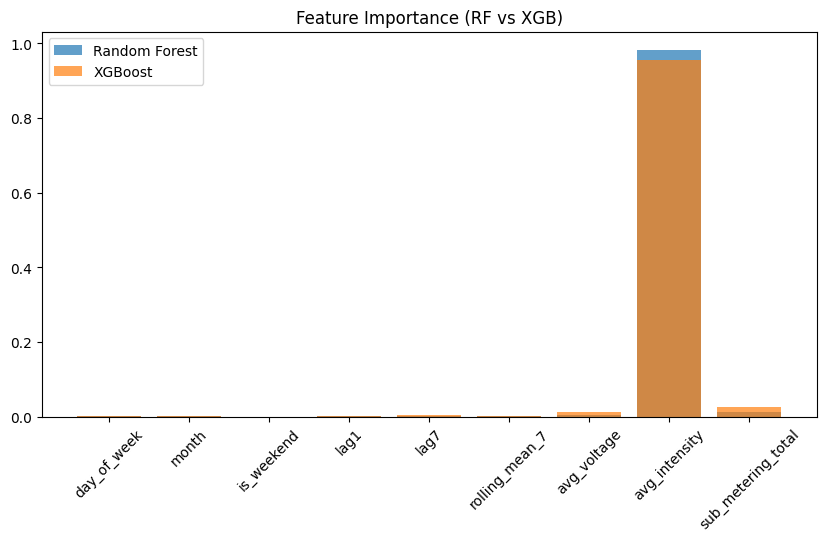

In [58]:
import matplotlib.pyplot as plt

# Random Forest
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

# Plot feature importances
features = X.columns
plt.figure(figsize=(10,5))
plt.bar(features, rf_importances, alpha=0.7, label="Random Forest")
plt.bar(features, xgb_importances, alpha=0.7, label="XGBoost")
plt.xticks(rotation=45)
plt.title("Feature Importance (RF vs XGB)")
plt.legend()
plt.show()

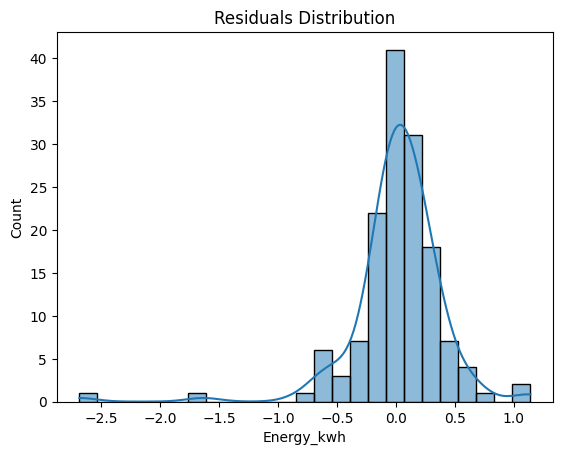

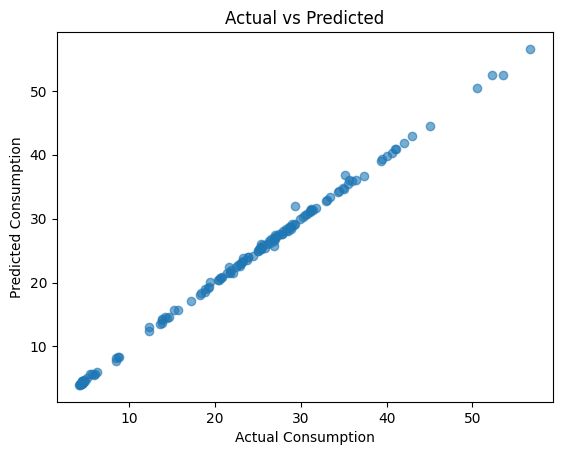

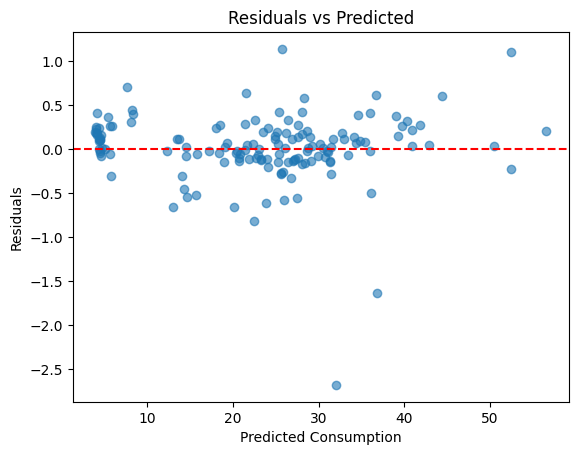

In [59]:
# Residuals
residuals = y_test - y_pred_lr

# Plot residuals distribution
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Scatter: actual vs predicted
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")
plt.title("Actual vs Predicted")
plt.show()

# Residuals vs predicted
plt.scatter(y_pred_lr, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Consumption")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


In [60]:
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01)

ridge_scores = cross_val_score(ridge, X, y, cv=5, scoring="r2")
lasso_scores = cross_val_score(lasso, X, y, cv=5, scoring="r2")

print("Ridge CV R²:", ridge_scores.mean())
print("Lasso CV R²:", lasso_scores.mean())

Ridge CV R²: 0.9910691272512151
Lasso CV R²: 0.9911686958282925


In [61]:
df['Derived_Intensity'] = (df['Global_active_power'] * 1000) / df['Voltage']
